In [24]:
from sklearn.model_selection import train_test_split
from __future__ import print_function
import os, sys, collections
import numpy as np
import re
from numpy import linalg as LA
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers.core import Dense, Flatten
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout, add, dot, Concatenate, LSTM, Merge
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Sequential, Model
from keras.constraints import unitnorm
import keras.backend as K
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from random import shuffle, sample

## Functions to import input files

In [188]:
def sanitize(sentence):
    answer = filter(lambda x: x.isalnum() or x == ' ', sentence)
    answer = re.sub(r'\s+', ' ', answer).lower()
    return answer

def readfile(fn, y_label):
    sen = []
    with open(fn, 'rU') as csv_file:
        reader = csv.reader(csv_file, delimiter=",")
        for row in reader:
            qid_, answer = row[:2]
            if qid_ == 'question_id' or qid_ == 'id':
                continue
            a, b, c, = row[2:]
            d = float(len(answer)/600.0) if float(len(answer)/600.0)<1 else 1.0
            qid = int(qid_)
            answer = sanitize(answer)
            sen.append([qid, y_label, answer, int(a), int(b), int(c), d])

    return sen

In [189]:
BEST_FILE = "/Users/yan/Code/lawyer_answer_spam_classifier/best.csv"
WORST_FILE = "/Users/yan/Code/lawyer_answer_spam_classifier/worst.csv"
best_sen = readfile(BEST_FILE, 1)
worst_sen = readfile(WORST_FILE, 0)
sen = best_sen + worst_sen[:5000]

In [190]:
best_sen[0]

[4094512,
 1,
 'nj has a very broad definition of what a tenant is in this case the ll has been aware of your partners presence for years unless they are in the habit of issuing access cards to strangers he is entitled to a card in my opinion you should send notice to the ll as required by the lease and ask for the reinstatement of cards alert them that you will escrow the rent if they do not reactivate the card',
 0,
 0,
 0,
 0.6816666666666666]

In [191]:
best_file = "/Users/yan/Code/lawyer_answer_spam_classifier/best.csv"
worst_file = "/Users/yan/Code/lawyer_answer_spam_classifier/worst.csv"
best_sen = readfile(best_file, 1)
worst_sen = readfile(worst_file, 0)
sen = best_sen + worst_sen[:5000]

In [192]:
len(best_sen), len(worst_sen)

(5000, 9999)

In [220]:
VOCAB_SIZE = 10000
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 200
np.random.seed(1337)

In [221]:
texts = [i[2] for i in sen]
tokenizer = Tokenizer(VOCAB_SIZE, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, split=" ", char_level=False)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
index_word = dict(zip(word_index.values(), word_index.keys()))
print('Found %s unique tokens.' % len(word_index))
print(len(sequences[2]),len(sequences))

Found 21297 unique tokens.
34 10000


In [222]:
for i in xrange(len(sequences)):
    sen[i].append(sequences[i])

In [223]:
y_label = [i[1] for i in sen]
X_train, X_test, label_train, label_test = train_test_split(sen, y_label, test_size=0.1, random_state=42)

In [224]:
X_train_data = [i[7]  for i in X_train]
X_test_data = [i[7]  for i in X_test]
X_train_feature = [i[3:7]  for i in X_train]
X_test_feature = [i[3:7]  for i in X_test]

In [225]:
X_train_data_arr = pad_sequences(X_train_data, maxlen=MAX_SEQUENCE_LENGTH, value=0)
X_test_data_arr = pad_sequences(X_test_data, maxlen=MAX_SEQUENCE_LENGTH, value=0)

In [226]:
label_train = np.asarray(label_train)
label_test = np.asarray(label_test)

In [227]:
X_train_feature_arr = np.asarray(X_train_feature)
X_test_feature_arr = np.asarray(X_test_feature)

In [228]:
len(label_train), len(label_test)

(9000, 1000)

## First approach with random initialization of embedding word vectors

In [239]:
extra_features = Input(shape=(4,)) 
extra_features_dense = Dense(4, )(extra_features)

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer_word = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH,embeddings_constraint=unitnorm(axis=1))
embedded_sequences = embedding_layer_word(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = concatenate([x, extra_features_dense])
Dropout (0.25)
preds = Dense(1, activation='sigmoid')(x)
model = Model(inputs = [sequence_input, extra_features], outputs=preds)
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])
model.fit([X_train_data_arr,X_train_feature_arr],label_train, validation_data=([X_test_data_arr,X_test_feature_arr], label_test),epochs=5, batch_size=128)

Train on 9000 samples, validate on 1000 samples
Epoch 1/5
9000/9000 [==============================] - 13s - loss: 0.4962 - acc: 0.7558 - val_loss: 0.3899 - val_acc: 0.8160

## Second approach: import Glove embedding vectors as initialization

In [234]:
def get_glove():
    glove_file = "/Users/yan/Code/keras_proj/glove.6B.100d.txt"
    with open(glove_file) as glove:
      lines = glove.readlines()
    glove = {}
    for line in lines:
        line_split = line.split(' ')
        word = line_split[0]
        embedding = np.array([float(val) for val in line_split[1:]])
        glove[word] = embedding
    return glove

In [235]:
glove = get_glove()

In [236]:
embedding_matrix = np.zeros((len(word_index)+1, 100))
for word, i in word_index.items():
    if word in glove:
        embedding_matrix[i] = glove.get(word)

In [238]:
extra_features = Input(shape=(4,)) 
extra_features_dense = Dense(4, )(extra_features)

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer_word = Embedding(input_dim=len(word_index)+1, output_dim=100, input_length=MAX_SEQUENCE_LENGTH,weights=[embedding_matrix],embeddings_constraint=unitnorm(axis=1))
embedded_sequences = embedding_layer_word(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
Dropout (0.25)
x = concatenate([x, extra_features_dense])
preds = Dense(1, activation='sigmoid')(x)
model = Model(inputs = [sequence_input, extra_features], outputs=preds)
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])
model.fit([X_train_data_arr,X_train_feature_arr], label_train, validation_data=([X_test_data_arr,X_test_feature_arr], label_test),epochs=5, batch_size=128)

Train on 9000 samples, validate on 1000 samples
Epoch 1/5
9000/9000 [==============================] - 14s - loss: 0.5295 - acc: 0.7328 - val_loss: 0.4481 - val_acc: 0.7970

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 200, 100)          1094200   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 196, 128)          64128     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4992)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                159776    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total para

## Draw confusion matrix

In [165]:
preds = model.predict([X_test_data_arr,X_test_feature_arr])
#cm = confusion_matrix(label_test, preds)

In [166]:
preds_class = [ 1 if i > 0.5 else 0 for i in preds]

In [167]:
X_test_output =[ [a[1], a[2], b[0], c] for a, b, c in zip(X_test, preds, preds_class)]

In [178]:
X_test_output[:3]

[[0, 'this is a duplicate question handled earlier today', 0.071521424, 0],
 [1,
  'it depends on how the restraining order is worded defendants often use third parties to do their dirty work when a retraining order has been issued against them that is why some but not all retraining orders ban the defendant from using third parties to contact the other party follow that person photograph them etc i would report the activity to the police department and make sure the incidents are documented you can also apply for a retaining order against these third parties for their creepy and disturbing actions if you are fearful of these third parties and want them to stay away from you your children and their schools go to the court and apply for a retaining order against that person this new significant other of your ex needs to be addressed by you in a legal manner as soon as possible if you do not the nonsense will escalate and you will be further tested by your ex and the new friend good luck

In [168]:
X_test_output[:3]

[[0, 'this is a duplicate question handled earlier today', 0.071521424, 0],
 [1,
  'it depends on how the restraining order is worded defendants often use third parties to do their dirty work when a retraining order has been issued against them that is why some but not all retraining orders ban the defendant from using third parties to contact the other party follow that person photograph them etc i would report the activity to the police department and make sure the incidents are documented you can also apply for a retaining order against these third parties for their creepy and disturbing actions if you are fearful of these third parties and want them to stay away from you your children and their schools go to the court and apply for a retaining order against that person this new significant other of your ex needs to be addressed by you in a legal manner as soon as possible if you do not the nonsense will escalate and you will be further tested by your ex and the new friend good luck

In [169]:
import csv
out = csv.writer(open("lawyer_spam_testset_output.csv","w"), delimiter='\n')
out.writerow(X_test_output)

In [170]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(label_test, np.asarray(preds_class))

In [171]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [172]:
label_test[:3]

array([0, 1, 1])

In [173]:
plot_confusion_matrix(cm, {'worst':0, 'best':1})

Confusion matrix, without normalization
[[349 159]
 [ 31 461]]


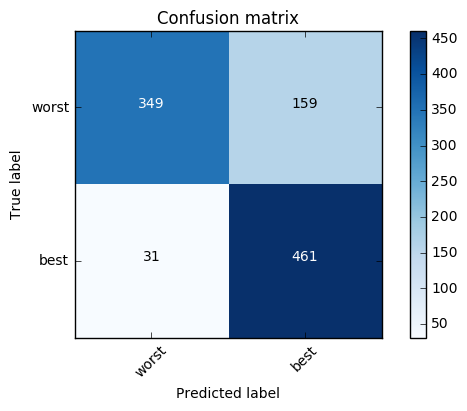

In [174]:
plt.show()